In [22]:
import matplotlib
import torch
from torch import nn
from torch.nn import functional as F
import dltools

In [23]:
batch_szie = 32
num_steps = 35
train_iter,vocab = dltools.load_data_time_machine(batch_size=batch_szie,num_steps=num_steps)


In [24]:
for x,y in train_iter:
    print(x,y)
    break

tensor([[ 5,  6,  2,  ..., 12,  2, 10],
        [21, 21, 12,  ...,  7, 14, 10],
        [ 7, 10,  2,  ..., 13,  5, 10],
        ...,
        [ 9,  2,  1,  ...,  1,  9,  2],
        [ 1,  8, 14,  ..., 12,  5, 15],
        [ 9,  2,  6,  ...,  7, 17,  6]]) tensor([[ 6,  2,  1,  ...,  2, 10,  1],
        [21, 12,  2,  ..., 14, 10,  1],
        [10,  2, 16,  ...,  5, 10,  2],
        ...,
        [ 2,  1,  9,  ...,  9,  2,  1],
        [ 8, 14, 21,  ...,  5, 15,  5],
        [ 2,  6,  1,  ..., 17,  6,  1]])


In [25]:
F.one_hot(torch.tensor([0,2]),num_classes=len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [26]:
X =torch.arange(10).reshape((2,5))
x = F.one_hot(X.T,28)

In [27]:
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.rand(size=shape,device=device) * 0.01
    
    W_xh = normal((num_inputs,num_hiddens))
    W_hh = normal((num_hiddens,num_hiddens))
    b_h= torch.zeros(num_hiddens,device = device)
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)
    params =[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params


In [28]:
get_params(28,512,'cuda:0')

[tensor([[6.3240e-03, 2.4670e-03, 8.4820e-03,  ..., 9.7334e-03, 5.2767e-03,
          4.6439e-03],
         [9.8331e-04, 8.9882e-03, 6.6439e-04,  ..., 6.9211e-03, 2.7301e-03,
          6.4258e-03],
         [1.9074e-03, 3.5266e-04, 2.5701e-03,  ..., 9.8777e-03, 1.2885e-03,
          9.6782e-03],
         ...,
         [5.1570e-03, 9.5742e-05, 7.3713e-03,  ..., 7.8003e-05, 6.9413e-03,
          8.7971e-04],
         [7.3462e-03, 2.7220e-03, 8.7481e-03,  ..., 3.3046e-03, 9.7988e-03,
          3.9209e-03],
         [2.8658e-03, 3.1004e-03, 7.4840e-03,  ..., 8.5954e-03, 3.3236e-03,
          9.6743e-03]], device='cuda:0', requires_grad=True),
 tensor([[0.0067, 0.0018, 0.0046,  ..., 0.0072, 0.0084, 0.0055],
         [0.0064, 0.0082, 0.0080,  ..., 0.0020, 0.0003, 0.0052],
         [0.0077, 0.0005, 0.0029,  ..., 0.0076, 0.0083, 0.0029],
         ...,
         [0.0084, 0.0076, 0.0026,  ..., 0.0023, 0.0044, 0.0041],
         [0.0016, 0.0071, 0.0092,  ..., 0.0048, 0.0029, 0.0089],
         [0.00

In [29]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

In [52]:
def run(inputs,state,params):
    W_xh,W_hh,b_h,W_hq,b_q = params
    H, = state
    outputs = []
    for X in  inputs:
        H = torch.tanh(torch.mm(X,W_xh) + torch.mm(H ,W_hh) + b_h)
        Y = torch.mm(H,W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)

class RNNModelScratch:
    def __init__(self,vocab_szie,num_hiddens,device,get_params,init_state,forward_fn):
        self.vocab_size ,self.num_hiddens = vocab_szie,num_hiddens
        self.params = get_params(vocab_szie,num_hiddens,device)
        self.init_state ,self.forward_fn = init_state,forward_fn
    def __call__(self,X,state):
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)
    

 

In [53]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_hiddens = 32
net = RNNModelScratch(len(vocab),num_hiddens,device ,get_params,init_rnn_state,run)
state = net.begin_state(X.shape[0],dltools.try_gpu())
Y,new_state = net(X.to(device),state)

In [54]:
Y.shape

torch.Size([10, 28])

In [72]:
def predict(prefix,num_preds,net,vocab,device):
    state = net.begin_state(batch_size=1,device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape(-1,1)
    for y in prefix[1:]:
        input = get_input()
        _,state = net(input,state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y,state = net(get_input(),state)
        outputs.append(y.argmax(dim=1).reshape(1))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


In [61]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm  = sum(torch.sum((p.grad ** 2)) for p in params)
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm

In [82]:
import math


def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, dltools.Timer()
    metric = dltools.Accumulator(2)  # [loss_sum, token_count]
    
    for X, y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        
        y = y.T.reshape(-1)              # [batch_size*num_steps]
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        
        metric.add(l * y.numel(), y.numel())
    
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


In [70]:
def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = dltools.Animator(xlabel='epoch', ylabel='perplexity',
                                legend=['train'], xlim=[10, num_epochs])

    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: dltools.sgd(net.params, lr, batch_size)

    pred = lambda prefix: predict(prefix, 50, net, vocab, device)

    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)

        if (epoch + 1) % 10 == 0:
            print(pred('time traveller'))
            animator.add(epoch + 1, [ppl])

    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(pred('time traveller'))
    print(pred('traveller'))


困惑度 4.5, 62453.1 词元/秒 cuda:0
time travellery you on to to in and the time traveller and the t
travellere all the time traveller and the time traveller an


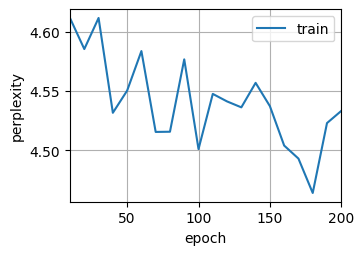

In [83]:
num_epoches ,lr = 200,0.1
train(net,train_iter,vocab,lr,num_epoches,dltools.try_gpu())

困惑度 5.2, 51681.2 词元/秒 cuda:0
time traveller have the time traveller and the time traveller an
travellere all the time traveller and the time traveller an


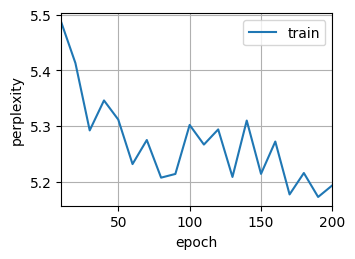

In [77]:
num_epoches ,lr = 200,0.1
train(net,train_iter,vocab,lr,num_epoches,dltools.try_gpu(),use_random_iter=True)

[epoch 200] ppl=12.110, speed=64985.7 tok/s, sample: time travellere the the the the the the the the the the the the 
最终：困惑度 12.110，速度 64985.7 词元/秒 on cuda:0
sample@prefix=time traveller:
 time travellere the the the the the the the the the the the the 
sample@prefix=traveller:
 travellere the the the the the the the the the the the the 


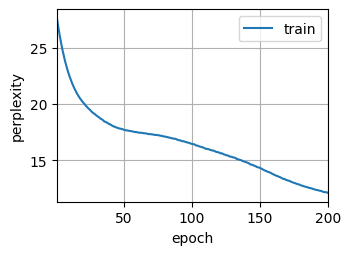

In [87]:
# ========= 1) imports & seed =========
import torch
from torch import nn
import torch.nn.functional as F
import math # 如果你本地是 dl，请改成: import d2l.torch as dltools

def set_seed(seed=1):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(1)

# ========= 2) 数据 =========
batch_size = 32
num_steps  = 35
train_iter, vocab = dltools.load_data_time_machine(batch_size=batch_size, num_steps=num_steps)

# ========= 3) 参数初始化 =========
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def rnd(shape):  # 正态初始化更常见，收敛更稳
        return (torch.randn(size=shape, device=device) * 0.01)

    W_xh = rnd((num_inputs,   num_hiddens))   # [V, H]
    W_hh = rnd((num_hiddens,  num_hiddens))   # [H, H]
    b_h  = torch.zeros(num_hiddens, device=device)      # [H]
    W_hq = rnd((num_hiddens,  num_outputs))   # [H, V]
    b_q  = torch.zeros(num_outputs, device=device)      # [V]

    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for p in params:
        p.requires_grad_(True)
    return params

# ========= 4) 隐藏状态初始化 =========
def init_rnn_state(batch_size, num_hiddens, device):
    # 返回单元素元组 (H,) —— 为了兼容 LSTM 的 (h, c) 形式
    return (torch.zeros((batch_size, num_hiddens), device=device),)

# ========= 5) RNN前向（手搓） =========
def rnn_forward(inputs, state, params):
    """inputs: [num_steps, batch_size, vocab_size] 的 one-hot
       state : (H,) 其中 H: [batch_size, num_hiddens]
       return: (Y_cat, (H,)),  Y_cat: [num_steps*batch_size, vocab_size]
    """
    W_xh, W_hh, b_h, W_hq, b_q = params
    (H,) = state
    outputs = []
    for X_t in inputs:  # 每个 X_t: [batch, V]
        H = torch.tanh(X_t @ W_xh + H @ W_hh + b_h)     # [batch, H]
        Y = H @ W_hq + b_q                              # [batch, V]
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

# ========= 6) 模型封装 =========
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size  = vocab_size
        self.num_hiddens = num_hiddens
        self.params      = get_params(vocab_size, num_hiddens, device)
        self.init_state  = init_state
        self.forward_fn  = forward_fn

    def __call__(self, X, state):
        # X: [batch, num_steps] 的整数索引 -> one-hot: [num_steps, batch, V]
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

# ========= 7) 梯度裁剪 =========
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = [p for p in net.params if p.requires_grad]

    # 计算全局范数
    norm_sq = 0.0
    for p in params:
        if p.grad is not None:
            norm_sq += float(torch.sum(p.grad ** 2))
    norm = math.sqrt(norm_sq)

    if norm > theta and norm > 0:
        scale = theta / (norm + 1e-9)
        for p in params:
            if p.grad is not None:
                p.grad.mul_(scale)

# ========= 8) 预测（贪心 / 采样 可选） =========
def predict(prefix, num_preds, net, vocab, device, sample=False, temperature=1.0):
    state   = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]  # 存放“索引”
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(-1, 1)

    # 预热：把前缀的其余字符喂进去，只更新 state
    for ch in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[ch])

    # 生成
    for _ in range(num_preds):
        y_hat, state = net(get_input(), state)            # y_hat: [1, V]
        if sample:
            probs = F.softmax(y_hat / max(1e-6, temperature), dim=1)
            next_id = int(torch.multinomial(probs, num_samples=1).item())
        else:
            next_id = int(y_hat.argmax(dim=1).item())
        outputs.append(next_id)
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# ========= 9) 单轮训练 =========
def train_epoch(net, train_iter, loss_fn, updater, device, use_random_iter):
    state, timer = None, dltools.Timer()
    metric = dltools.Accumulator(2)  # 累计 [loss_sum, token_count]

    for X, y in train_iter:
        # state 初始化/重置
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 断开计算图
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state = state.detach()
            else:
                state = tuple(s.detach() for s in state)

        # 形状对齐
        # y: [batch, num_steps] -> [num_steps, batch] -> [-1]
        y = y.T.reshape(-1)
        X, y = X.to(device), y.to(device)

        # 前向 & loss
        y_hat, state = net(X, state)       # y_hat: [num_steps*batch, V]
        l = loss_fn(y_hat, y.long()).mean()

        # 反传 & 更新
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)  # 对手搓 sgd：传 batch_size 用于平均

        # 统计
        metric.add(l * y.numel(), y.numel())

    ppl   = math.exp(metric[0] / metric[1])
    speed = metric[1] / timer.stop()  # 词元/秒
    return ppl, speed

# ========= 10) 训练主循环 =========
def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = dltools.Animator(
        xlabel='epoch', ylabel='perplexity', legend=['train'],
        xlim=[1, num_epochs]
    )

    # 选择优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        # 使用 d2l 的简易 sgd（如果你没有，也可自写一个）
        updater = lambda batch_size: dltools.sgd(net.params, lr, batch_size)

    # 便捷的预测函数
    pred = lambda prefix: predict(prefix, 50, net, vocab, device)

    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)
        animator.add(epoch + 1, [ppl])
        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            print(f'[epoch {epoch+1}] ppl={ppl:.3f}, speed={speed:.1f} tok/s, sample: {pred("time traveller")[:80]}')

    print(f'最终：困惑度 {ppl:.3f}，速度 {speed:.1f} 词元/秒 on {device}')
    print('sample@prefix=time traveller:\n', pred('time traveller'))
    print('sample@prefix=traveller:\n',     predict('traveller', 50, net, vocab, device))

# ========= 11) 组网 & 开训 =========
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_hiddens = 32     # 小到 32 也能跑，但想把 PPL 压到 ~1，建议 256/512
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn_forward)
train(net, train_iter, vocab, lr=0.1, num_epochs=200, device=device, use_random_iter=False)
